# Importing request

In [1]:
import requests
import json
from pprint import pprint
import pandas as pd
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import numpy as np
from config import api_key
from config import api_id
from config import api_key2

# Creating random list for MSAs
Keith wrote the code to generate the random list from the top polluting MSAs

In [2]:
# The data to load
f = "../data/msa.csv"

# Count the lines
num_lines = sum(1 for l in open(f))

# Sample size - retrieving header and 5 MSA's
size = 10

# The row indices to skip - make sure 0 is not included to keep the header
skip_idx = random.sample(range(1, num_lines), num_lines - size)

# Read the data
msa = pd.read_csv(f, skiprows=skip_idx)

# Display the sample
msa


,MSA
0,"Atlanta-Athens-Clarke County-Sandy Springs, G..."
1,"Birmingham-Hoover-Talladega, AL"
2,"Chicago-Naperville, IL-IN-WI"
3,"Cleveland-Akron-Canton, OH"
4,"Houston-The Woodlands, TX"
5,"McAllen-Edinburg, TX"
6,"Medford-Grants Pass, OR"
7,"Sacramento-Roseville, CA"
8,"Shreveport-Bossier City-Minden, LA"


# Striping Leading/Trailing Spaces for Merge

In [3]:
msa['MSA1']=msa['MSA'].str.strip()
msa

,MSA,MSA1
0,"Atlanta-Athens-Clarke County-Sandy Springs, G...","Atlanta-Athens-Clarke County-Sandy Springs, GA-AL"
1,"Birmingham-Hoover-Talladega, AL","Birmingham-Hoover-Talladega, AL"
2,"Chicago-Naperville, IL-IN-WI","Chicago-Naperville, IL-IN-WI"
3,"Cleveland-Akron-Canton, OH","Cleveland-Akron-Canton, OH"
4,"Houston-The Woodlands, TX","Houston-The Woodlands, TX"
5,"McAllen-Edinburg, TX","McAllen-Edinburg, TX"
6,"Medford-Grants Pass, OR","Medford-Grants Pass, OR"
7,"Sacramento-Roseville, CA","Sacramento-Roseville, CA"
8,"Shreveport-Bossier City-Minden, LA","Shreveport-Bossier City-Minden, LA"


In [4]:
str(len(msa))

'9'

# Reading in MSA Crosswalk info for MSA codes

In [5]:
file = "../data/msa_crosswalk.csv"
crosswalk = pd.read_csv(file)
crosswalk1 = crosswalk[['CBSA Code','CSA Title']].sort_values('CSA Title',ascending = False).rename(columns = {'CSA Title':'MSA1'}).dropna().drop_duplicates()
crosswalk1.head()

,CBSA Code,MSA1
1503,41400,"Youngstown-Warren, OH-PA"
1893,49660,"Youngstown-Warren, OH-PA"
1865,48700,"Williamsport-Lock Haven, PA"
974,30820,"Williamsport-Lock Haven, PA"
1860,48620,"Wichita-Arkansas City-Winfield, KS"


# Joining MSA Crosswalk to Top MSAs to get the CBSA Codes needed for API Pulls

In [6]:
msa_codes = pd.merge(crosswalk1,msa,
                how = 'inner',
                on = 'MSA1')

print(msa_codes.head())
print('-----------------------------------------------------------------------')
print("There are multiple CBSA Codes per MSA, there were " + str(len(msa)) +" codes before join and  "+ str(len(msa_codes)) +" CBSA codes after the join.")

  CBSA Code                      MSA1                        MSA
0     40900  Sacramento-Roseville, CA   Sacramento-Roseville, CA
1     46020  Sacramento-Roseville, CA   Sacramento-Roseville, CA
2     49700  Sacramento-Roseville, CA   Sacramento-Roseville, CA
3     32780   Medford-Grants Pass, OR    Medford-Grants Pass, OR
4     24420   Medford-Grants Pass, OR    Medford-Grants Pass, OR
-----------------------------------------------------------------------
There are multiple CBSA Codes per MSA, there were 9 codes before join and  27 CBSA codes after the join.


# API Call - Pollution Part 1
using a for loop to loop through three years work of PM2.5 data

In [7]:
response_sample = []
start = ["20140101","20130101","20120101"]
end = ["20141231","20131231","20121231"]
codes = msa_codes['CBSA Code']


for index in range(len(start)):
    for each_msa in codes:
        url = f"https://aqs.epa.gov/data/api/sampleData/byCBSA?email={api_id}&key={api_key}&param=88101&bdate={start[index]}&edate={end[index]}&cbsa={each_msa}"
        response_sample.append(requests.get(url).json())

# Pulling Data and putting in list
There are two loops, the first loop is through the 33 different MSAs. Unfortunately the EPA does not always sample every 3 dyas like their website says. This leads to certain sampling sites having different lengths of samples. The second loop goes from 0 to the length of the number of samples they do have

In [8]:
time = []
date = []
cbsa_code = []
site = []
sample = []


for x in range(len(response_sample)):
# for x in range(0,32):
    for y in range(0,response_sample[x]['Header'][0]['rows']):
        time.append(response_sample[x]['Data'][y]['time_local'])
        date.append(response_sample[x]['Data'][y]['date_local'])
        cbsa_code.append(response_sample[x]['Data'][y]['cbsa_code'])
        site.append(response_sample[x]['Data'][y]['site_number'])
        sample.append(response_sample[x]['Data'][y]['sample_measurement'])

columns = ['time','date','cbsa_code','site','sample']
df_sample = pd.DataFrame(data = list(zip(time,date,cbsa_code,site,sample)), columns = columns)

df_sample.head()

,time,date,cbsa_code,site,sample
0,00:00,2014-01-01,40900,0012,16.0
1,01:00,2014-01-01,40900,0012,25.0
2,02:00,2014-01-01,40900,0012,14.0
3,03:00,2014-01-01,40900,0012,12.0
4,04:00,2014-01-01,40900,0012,11.0


# Converting date to DateTime
needed to group by month which is format that Oil Data is in

In [9]:
df_sample['date'] = pd.to_datetime(df_sample.date,format = '%Y-%m')
print(df_sample.head(1))
print('---------------------------------------------------------')
print("There are "+ str(len(df_sample)) +" rows of PM2.5 data")

    time       date cbsa_code  site  sample
0  00:00 2014-01-01     40900  0012    16.0
---------------------------------------------------------
There are 214547 rows of PM2.5 data


In [10]:
df_sample['month_year'] = df_sample['date'].dt.strftime('%m-%Y')
df_sample.head(1)

,time,date,cbsa_code,site,sample,month_year
0,00:00,2014-01-01,40900,0012,16.0,01-2014


converting sample to float to be used for regression/analysis later

In [11]:
df_sample= df_sample.astype({'sample': float})

# Grouping Hourly Data by day & Merging
PM2.5 data is organized by hour, but we need it on a daily level so it can map in with the AQI levels. First we do a groupby to get daily levels, then we need to remerge with the original data to get the categorical data back in (county, site, lat, lon)

In [12]:
df_sample1 = df_sample[['site','sample','month_year','cbsa_code']].groupby(['month_year','cbsa_code','site']).mean().reset_index().sort_values('month_year',ascending = False)
df_sample1.head()
len(df_sample1)
print(df_sample1.head(3))
print('-----------------------------------------')
print('There are '+ str(len(df_sample1)) + ' rows after grouping')

     month_year cbsa_code  site     sample
2180    12-2014     49700  0003   7.270000
2134    12-2014     16980  0007  12.140000
2148    12-2014     16980  3301  11.236364
-----------------------------------------
There are 2181 rows after grouping


# Creating Dummy Variables for Time and Sites

In [13]:
sample1 = pd.get_dummies(df_sample1[['month_year','site']])
sample1.head()

,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,month_year_02-2014,month_year_03-2012,month_year_03-2013,month_year_03-2014,month_year_04-2012,...,site_2059,site_3002,site_3103,site_3301,site_4001,site_4002,site_4007,site_4201,site_6004,site_6005
2180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2147,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Merging Dummy Variables Back In

In [14]:
sample2 = pd.concat([df_sample1,sample1],axis = 1).dropna()
sample2.head(2)

,month_year,cbsa_code,site,sample,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,month_year_02-2014,...,site_2059,site_3002,site_3103,site_3301,site_4001,site_4002,site_4007,site_4201,site_6004,site_6005
2180,12-2014,49700,0003,7.27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2134,12-2014,16980,0007,12.14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# API Call Census Data
pulling on 5 polluted state/counties from random selection of the top 20 highest polluted counties in the US

pulling sectors for mining/quarring, utilities, construction, manufactoring, & wholesale trade

https://classcodes.com/naics-2-digit-sector-codes/

In [15]:
year_survey = ['2016','2015','2014']
year_actual = ['2014','2013','2012']
variables_interest = ['NAICS2012_TTL,EMP,ESTAB']
sectors = ["31-33","21","22","42","48-49"]
# sectors =["31-33"]
codes = msa_codes['CBSA Code']
response_census = []
year_date = []


for index in range(len(year_survey)):
    for each_msa in codes:
        try:
            base_url = f"https://api.census.gov/data/{year_survey[index]}/cbp?get={variables_interest[0]}&NAICS2012={sectors[0]}&NAICS2012={sectors[1]}&NAICS2012={sectors[2]}&NAICS2012={sectors[3]}&NAICS2012={sectors[4]}&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:{each_msa}&key={api_key2}"
            response_census.append(requests.get(base_url).json())
            year_date.append(year_actual[index])
        except:
            print(f'MSA {each_msa} not found')

MSA 10760 not found
MSA 10760 not found
MSA 10760 not found


In [16]:
naics2012_ttl = []
cbsa_code = []
emp = []
estab = []
sector = []
date = []

for x in range(len(response_census)):
    for y in range(1,5):
        sector.append(response_census[x][y][0])
        cbsa_code.append(response_census[x][y][4])
        emp.append(response_census[x][y][1])
        estab.append(response_census[x][y][2]) 

# Creating Census Dataset from Pulled Data
dropping first index as it is the column heading

In [17]:
columns = ['sector','cbsa_code','emp','estab','year']
census = pd.DataFrame(data = list(zip(sector,cbsa_code,emp,estab,year_date)), columns = columns)
print(census.head(3))
print('-----------------------------------------')
print('There are '+ str(len(census)) + ' rows')

                                          sector cbsa_code    emp estab  year
0  Mining, quarrying, and oil and gas extraction     40900    236    30  2014
1                                      Utilities     40900   3410    52  2014
2                                  Manufacturing     40900  33879  1368  2014
-----------------------------------------
There are 78 rows


# Creating Dummy Variables for Categorical Data of Industries and CBSA Codes

In [18]:
df2 = pd.get_dummies(census[['sector','year','cbsa_code']])
df2.head()

,sector_Manufacturing,"sector_Mining, quarrying, and oil and gas extraction",sector_Transportation and warehousing,sector_Utilities,sector_Wholesale trade,year_2012,year_2013,year_2014,cbsa_code_10420,cbsa_code_11780,...,cbsa_code_26660,cbsa_code_32580,cbsa_code_32780,cbsa_code_35420,cbsa_code_35940,cbsa_code_40100,cbsa_code_40900,cbsa_code_41780,cbsa_code_46020,cbsa_code_49700
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


# Concatenating Dummy Variables back in

In [19]:
census_final = pd.concat([df2,census],axis = 1).dropna()
census_final.head()

,sector_Manufacturing,"sector_Mining, quarrying, and oil and gas extraction",sector_Transportation and warehousing,sector_Utilities,sector_Wholesale trade,year_2012,year_2013,year_2014,cbsa_code_10420,cbsa_code_11780,...,cbsa_code_40100,cbsa_code_40900,cbsa_code_41780,cbsa_code_46020,cbsa_code_49700,sector,cbsa_code,emp,estab,year
0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,"Mining, quarrying, and oil and gas extraction",40900,236,30,2014
1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,Utilities,40900,3410,52,2014
2,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,Manufacturing,40900,33879,1368,2014
3,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,Wholesale trade,40900,35499,2034,2014
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",46020,32,10,2014


In [20]:
census_final= census_final.astype({'emp': float,
                                  'estab':float})
census_final.head()

,sector_Manufacturing,"sector_Mining, quarrying, and oil and gas extraction",sector_Transportation and warehousing,sector_Utilities,sector_Wholesale trade,year_2012,year_2013,year_2014,cbsa_code_10420,cbsa_code_11780,...,cbsa_code_40100,cbsa_code_40900,cbsa_code_41780,cbsa_code_46020,cbsa_code_49700,sector,cbsa_code,emp,estab,year
0,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,"Mining, quarrying, and oil and gas extraction",40900,236.0,30.0,2014
1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,Utilities,40900,3410.0,52.0,2014
2,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,Manufacturing,40900,33879.0,1368.0,2014
3,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,Wholesale trade,40900,35499.0,2034.0,2014
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",46020,32.0,10.0,2014


# Reading in and Cleaning Oil Data

In [21]:
#remove rows before 198
file = "../data/Crude_oil_prices.csv"
oil = pd.read_csv(file)
oil_data=oil[(oil['Year']>1984)]
oil_data['date'] = pd.to_datetime(oil_data[['Year', 'Month']].assign(DAY=1))
oil_data= oil_data.drop(columns=['Free on Board Cost of Crude Oil Imports (Dollars per Barrel)',
                                 'Landed Cost of Crude Oil Imports (Dollars per Barrel)',
                                 'Refiner Acquisition Cost of Crude Oil, Domestic (Dollars per Barrel)',
                                 'Refiner Acquisition Cost of Crude Oil, Imported (Dollars per Barrel)',
                                 'Refiner Acquisition Cost of Crude Oil, Composite (Dollars per Barrel)','Month','Year'])
oil_data.head()

C:\Users\adfil\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Crude Oil Domestic First Purchase Price (Dollars per Barrel),date
159,24.26,1985-01-01
160,23.64,1985-02-01
161,23.89,1985-03-01
162,24.19,1985-04-01
163,24.18,1985-05-01


In [22]:
oil_data= oil_data.rename(columns={"Crude Oil Domestic First Purchase Price (Dollars per Barrel)":'Crude_Oil_Price'})
oil_data= oil_data[['date','Crude_Oil_Price']]
index= oil_data[(oil_data['Crude_Oil_Price'] =='Not Available')].index

oil_data.drop(index, inplace=True)

oil_data.head()

,date,Crude_Oil_Price
159,1985-01-01,24.26
160,1985-02-01,23.64
161,1985-03-01,23.89
162,1985-04-01,24.19
163,1985-05-01,24.18


In [23]:
oil_data['month_year'] = oil_data['date'].dt.strftime('%m-%Y')
oil_data.head()

,date,Crude_Oil_Price,month_year
159,1985-01-01,24.26,01-1985
160,1985-02-01,23.64,02-1985
161,1985-03-01,23.89,03-1985
162,1985-04-01,24.19,04-1985
163,1985-05-01,24.18,05-1985


In [24]:
oil_data= oil_data.astype({'Crude_Oil_Price': float})
oil_data.head()

,date,Crude_Oil_Price,month_year
159,1985-01-01,24.26,01-1985
160,1985-02-01,23.64,02-1985
161,1985-03-01,23.89,03-1985
162,1985-04-01,24.19,04-1985
163,1985-05-01,24.18,05-1985


In [25]:
oil_data1 = oil_data.groupby('month_year').mean().reset_index()
oil_data1.head()

,month_year,Crude_Oil_Price
0,01-1985,24.26
1,01-1986,23.12
2,01-1987,13.79
3,01-1988,13.64
4,01-1989,13.80


# Merging in Oil Prices into Census & Pollution Data

In [26]:
pm25_census = pd.merge(sample2, census_final,
                      how = 'inner',
                      on = 'cbsa_code')
pm25_census.head()

,month_year,cbsa_code,site,sample,month_year_01-2012,month_year_01-2013,month_year_01-2014,month_year_02-2012,month_year_02-2013,month_year_02-2014,...,cbsa_code_35940,cbsa_code_40100,cbsa_code_40900,cbsa_code_41780,cbsa_code_46020,cbsa_code_49700,sector,emp,estab,year
0,12-2014,49700,0003,7.270000,0,0,0,0,0,0,...,0,0,0,0,0,1,"Mining, quarrying, and oil and gas extraction",138.0,10.0,2014
1,12-2014,49700,0003,7.270000,0,0,0,0,0,0,...,0,0,0,0,0,1,Utilities,279.0,11.0,2014
2,12-2014,49700,0003,7.270000,0,0,0,0,0,0,...,0,0,0,0,0,1,Manufacturing,1966.0,90.0,2014
3,12-2014,49700,0003,7.270000,0,0,0,0,0,0,...,0,0,0,0,0,1,Wholesale trade,2086.0,108.0,2014
4,12-2013,49700,0003,17.592308,0,0,0,0,0,0,...,0,0,0,0,0,1,"Mining, quarrying, and oil and gas extraction",138.0,10.0,2014


In [27]:
pm25_census_oil = pd.merge(pm25_census, oil_data1,
                          how = 'inner',
                          on = 'month_year')
pm25_census_oil.head()
list(pm25_census_oil.columns)

['month_year',
 'cbsa_code',
 'site',
 'sample',
 'month_year_01-2012',
 'month_year_01-2013',
 'month_year_01-2014',
 'month_year_02-2012',
 'month_year_02-2013',
 'month_year_02-2014',
 'month_year_03-2012',
 'month_year_03-2013',
 'month_year_03-2014',
 'month_year_04-2012',
 'month_year_04-2013',
 'month_year_04-2014',
 'month_year_05-2012',
 'month_year_05-2013',
 'month_year_05-2014',
 'month_year_06-2012',
 'month_year_06-2013',
 'month_year_06-2014',
 'month_year_07-2012',
 'month_year_07-2013',
 'month_year_07-2014',
 'month_year_08-2012',
 'month_year_08-2013',
 'month_year_08-2014',
 'month_year_09-2012',
 'month_year_09-2013',
 'month_year_09-2014',
 'month_year_10-2012',
 'month_year_10-2013',
 'month_year_10-2014',
 'month_year_11-2012',
 'month_year_11-2013',
 'month_year_11-2014',
 'month_year_12-2012',
 'month_year_12-2013',
 'month_year_12-2014',
 'site_0001',
 'site_0002',
 'site_0003',
 'site_0004',
 'site_0005',
 'site_0006',
 'site_0007',
 'site_0010',
 'site_0011

In [28]:
y = pm25_census_oil['sample']
x = pm25_census_oil[['Crude_Oil_Price','sector_Manufacturing','sector_Mining, quarrying, and oil and gas extraction','sector_Transportation and warehousing','sector_Utilities','emp','estab','year_2012','year_2013']]

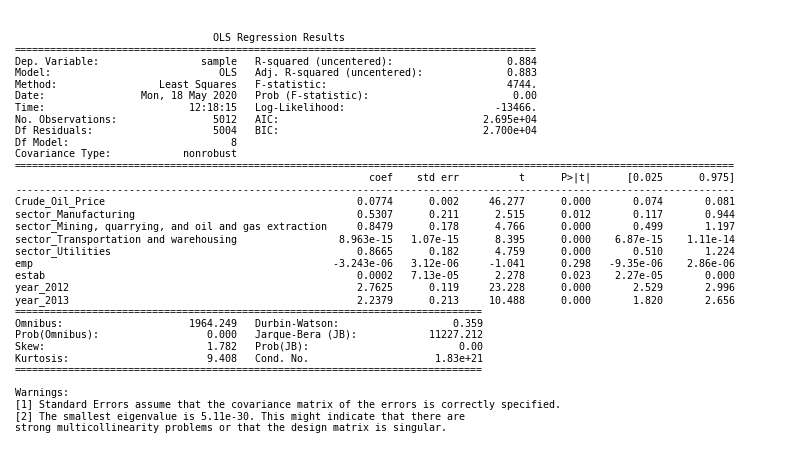

In [29]:
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.show()

# Exporting PM2.5, Census, Oil Data to CSV to use in Tableau

In [42]:
export_file = pm25_census_oil[['Crude_Oil_Price','sector','sample','site','month_year','emp','estab','cbsa_code']]

export_file.to_csv('../data/pm25_census_oil.csv')


# Machine Learning
#### Preprocessing
dropping categorical variables, and one variable for reference variable 

#### Reshaping data

In [32]:
X = pm25_census_oil.drop(columns = [
    'month_year','cbsa_code','site','sample','sector','year',
    'cbsa_code_49700','year_2014','year_2012','year_2013',
    'month_year_12-2014'])

y = pm25_census_oil['sample'].values.reshape(-1,1)
print(X.shape,y.shape)


(5012, 116) (5012, 1)


#### Splitting and Training Data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [35]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [36]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

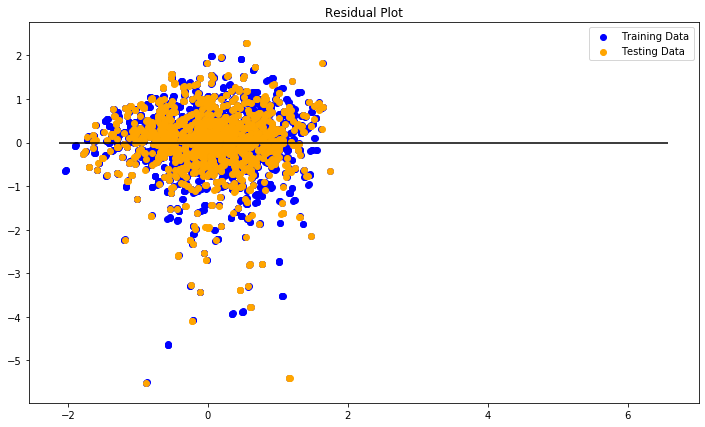

In [37]:
### BEGIN SOLUTION
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [38]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

NameError: name 'mean_squared_error' is not defined

In [39]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

NameError: name 'mean_squared_error' is not defined

In [40]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

NameError: name 'mean_squared_error' is not defined